# Autonomous driving - Car detection

You will learn about object detection using the very powerful YOLO model. Many of the ideas in this notebook are described in the two YOLO papers: Redmon et al., 2016 (https://arxiv.org/abs/1506.02640) and Redmon and Farhadi, 2016 (https://arxiv.org/abs/1612.08242). 

**You will learn to**:
- Use object detection on a car detection dataset
- Deal with bounding boxes


In [1]:
%tensorflow_version 1.x
import tensorflow
print(tensorflow.__version__)

TensorFlow 1.x selected.
1.15.2


In [2]:
!pip install scipy==1.1.0
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from skimage.transform import resize
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from yolo_utils import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes, scale_boxes
from yad2k import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body

%matplotlib inline

Using TensorFlow backend.


## 1 - Problem Statement

You are working on a self-driving car. As a critical component of this project, you'd like to first build a car detection system. To collect data, you've mounted a camera to the hood (meaning the front) of the car, which takes pictures of the road ahead every few seconds while you drive around. 

<center>
<video width="400" height="200" src="nb_images/road_video_compressed2.mp4" type="video/mp4" controls>
</video>
</center>

<caption><center> Pictures taken from a car-mounted camera while driving around Silicon Valley. <br> We would like to especially thank [drive.ai](https://www.drive.ai/) for providing this dataset! Drive.ai is a company building the brains of self-driving vehicles.
</center></caption>

<img src="nb_images/driveai.png" style="width:100px;height:100;">

You've gathered all these images into a folder and have labelled them by drawing bounding boxes around every car you found. Here's an example of what your bounding boxes look like.

<img src="nb_images/box_label.png" style="width:500px;height:250;">
<caption><center> <u> **Figure 1** </u>: **Definition of a box**<br> </center></caption>

If you have 80 classes that you want YOLO to recognize, you can represent the class label $c$ either as an integer from 1 to 80, or as an 80-dimensional vector (with 80 numbers) one component of which is 1 and the rest of which are 0. The video lectures had used the latter representation; in this notebook, we will use both representations, depending on which is more convenient for a particular step.  

In this exercise, you will learn how YOLO works, then apply it to car detection. Because the YOLO model is very computationally expensive to train, we will load pre-trained weights for you to use. 

## 2 - YOLO

In [3]:
def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):
    box_scores = box_confidence*box_class_probs
    box_classes = K.argmax(box_scores,-1)
    box_class_scores = K.max(box_scores,-1)
    filtering_mask = box_class_scores>threshold
    scores = tf.boolean_mask(box_class_scores,filtering_mask)
    boxes = tf.boolean_mask(boxes,filtering_mask)
    classes = tf.boolean_mask(box_classes,filtering_mask)
 
    return scores, boxes, classes

In [4]:
def iou(box1, box2):
    xi1 = max(box1[0],box2[0])
    yi1 = max(box1[1],box2[1])
    xi2 = min(box1[2],box2[2])
    yi2 = min(box1[3],box2[3])
    inter_area = (yi2-yi1)*(xi2-xi1)
    box1_area = (box1[3]-box1[1])*(box1[2]-box1[0])
    box2_area = (box2[3]-box2[1])*(box2[2]-box2[0])
    union_area = box1_area+box2_area-inter_area
    iou = inter_area/union_area
 
    return iou

In [5]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')
    K.get_session().run(tf.variables_initializer([max_boxes_tensor]))
    nms_indices = tf.image.non_max_suppression(boxes,scores,max_boxes,iou_threshold)
    scores = K.gather(scores,nms_indices)
    boxes = K.gather(boxes,nms_indices)
    classes = K.gather(classes,nms_indices)

    return scores, boxes, classes

In [6]:
yolo_outputs = (tf.random_normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1),
                   tf.random_normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                   tf.random_normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                   tf.random_normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1))

In [7]:
def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs
    boxes = yolo_boxes_to_corners(box_xy, box_wh)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = score_threshold)
    boxes = scale_boxes(boxes, image_shape)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)

    return scores, boxes, classes

In [8]:
scores, boxes, classes = yolo_eval(yolo_outputs)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [9]:
with tf.Session() as test_b:
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))

scores[2] = 138.79124
boxes[2] = [1292.3297  -278.52167 3876.9893  -835.56494]
classes[2] = 54


In [10]:
from google.colab import files
files.upload() #upload kaggle.json

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


In [12]:
#!kaggle datasets download -d rmoharir8396/yolo-h5-file
!unzip yolo-h5-file.zip
!mv yolo.h5 model_data/yolo.h5

Archive:  yolo-h5-file.zip
  inflating: yolo.h5                 


In [13]:
sess = K.get_session()
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")

yolo_model = load_model("model_data/yolo.h5", compile=False)

In [14]:
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))

In [15]:
def predict(sess, image_file):
    image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))
    out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes], feed_dict={yolo_model.input: image_data, K.learning_phase(): 0})

    print('Found {} boxes for {}'.format(len(out_boxes), image_file))

    # Generate colors for drawing bounding boxes.
    colors = generate_colors(class_names)

    # Draw bounding boxes on the image file
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)

    # Save the predicted bounding box on the image
    image.save(os.path.join("out", image_file), quality=90)

    # Display the results in the notebook
    output_image = scipy.misc.imread(os.path.join("out", image_file))

    plt.figure(figsize=(12,12))
    imshow(output_image)

    return out_scores, out_boxes, out_classes

In [16]:
img = plt.imread('images/test.jpg')
image_shape = float(img.shape[0]), float(img.shape[1])
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

Found 3 boxes for test.jpg
car 0.62 (773, 300) (937, 401)
car 0.80 (943, 327) (1280, 693)
car 0.83 (363, 297) (747, 651)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


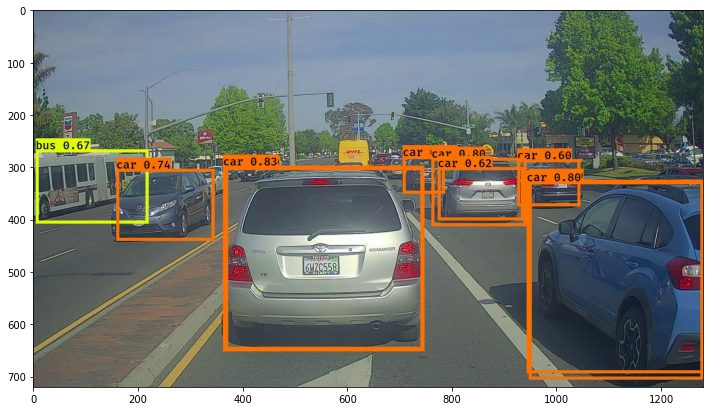

In [17]:
out_scores, out_boxes, out_classes = predict(sess, "test.jpg")

<font color='blue'>
**Summary for YOLO**:
- Input image (608, 608, 3)
- The input image goes through a CNN, resulting in a (19,19,5,85) dimensional output. 
- After flattening the last two dimensions, the output is a volume of shape (19, 19, 425):
    - Each cell in a 19x19 grid over the input image gives 425 numbers. 
    - 425 = 5 x 85 because each cell contains predictions for 5 boxes, corresponding to 5 anchor boxes, as seen in lecture. 
    - 85 = 5 + 80 where 5 is because $(p_c, b_x, b_y, b_h, b_w)$ has 5 numbers, and and 80 is the number of classes we'd like to detect
- You then select only few boxes based on:
    - Score-thresholding: throw away boxes that have detected a class with a score less than the threshold
    - Non-max suppression: Compute the Intersection over Union and avoid selecting overlapping boxes
- This gives you YOLO's final output. 

**References**: The ideas presented in this notebook came primarily from the two YOLO papers. The implementation here also took significant inspiration and used many components from Allan Zelener's github repository. The pretrained weights used in this exercise came from the official YOLO website. 
- Joseph Redmon, Santosh Divvala, Ross Girshick, Ali Farhadi - [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640) (2015)
- Joseph Redmon, Ali Farhadi - [YOLO9000: Better, Faster, Stronger](https://arxiv.org/abs/1612.08242) (2016)
- Allan Zelener - [YAD2K: Yet Another Darknet 2 Keras](https://github.com/allanzelener/YAD2K)
- The official YOLO website (https://pjreddie.com/darknet/yolo/) 

**Car detection dataset**:
<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">The Drive.ai Sample Dataset</span> (provided by drive.ai) is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>. We are especially grateful to Brody Huval, Chih Hu and Rahul Patel for collecting and providing this dataset. 